# つくりながら学ぶ！深層強化学習 PyTorchによる実践プログラミング

## 迷路問題

前回までで、行動反復法と価値反復法による強化学習アルゴリズムを実装してきた

今回は、これらのアルゴリズムを選択して強化学習できるようにフレームワークを作成して汎用化してみる

## モジュール分割

ここまで作ってきた迷路問題のコードを分割してみる

まずは、強化学習なしで単純にエージェントを動かす部分だけを考える（[01_01-maze.ipynb](./01_01-maze.ipynb) まで）

今回は、エージェントを動かす汎用的な関数を考え、そこからトップダウンでコードの構成を設計していく

迷路問題を解く関数（迷路内をエージェントがゴールするまで移動させる関数）は以下のようなものだった

```julia
maze(pi::Matrix) = begin
    # スタート地点: S0, ゴール地点: S8
    start, goal = 1, 9

    state::Int = start # 状態: 初期値 = S0
    state_history::Vector{Int} = [1] # エージェントの移動記録

    # ゴールするまで step を繰り返す
    while state !== goal
        state = next_state(pi, state)
        push!(state_history, state)
    end

    state_history
end
```

これを汎用化した関数を擬似コードで考えてみる

ここでは、以下のような形で考えてみた

```julia
エージェント実行!(エージェント, 方策; イベント = デフォルトイベント) = begin
    エージェント初期化!(エージェント)
    イベント(OnInit, エージェント, 方策) # エージェントの移動記録用配列の作成等を想定

    while !エージェント終了判定(エージェント)
        行動空間 = 行動空間取得(エージェント) # 行動空間: 行動の選択肢
        現在の状態 = 現在の状態取得(エージェント)
        次の行動 = 方策(行動空間, 現在の状態)

        継続フラグ = イベント(BeforeAction, エージェント, 方策, 現在の状態, 次の行動) # エージェントの移動記録等を想定
        !継続フラグ && break # ループを途中で抜ける

        エージェント行動!(エージェント, 次の行動) # 次の状態に遷移

        継続フラグ = イベント(AfterAction, エージェント, 方策)
        !継続フラグ && break # ループを途中で抜ける
    end

    イベント(OnEnd, エージェント, 方策)
end
```

ここから必要なインターフェイスを実装していく

In [3]:
# 再定義可能な構造体を定義するマクロ等を使えるようにする
include("./inc/retype.jl")

#=
エージェント
- Interface:
    - 初期化: ()! <- 状態等の内部データを初期化
    - 終了判定: () -> (終了フラグ)
    - 行動空間取得: () -> (行動空間)
    - 現在の状態取得: () -> (現在の状態)
    - 行動実行: (行動)! <- 次の状態へ遷移
=#
@retype abstract type AbstractAgent end

# インターフェイス定義のための関数は、実装されずに使われることを想定していないので例外処理を定義しておく
init!(::AbstractAgent) = error("init!(::AbstractAgent): Initialize the agent.")
is_terminated(::AbstractAgent) = error("is_terminated(::AbstractAgent) -> (is_terminated::Boolean): Determine if the agent is terminated.")
action_space(::AbstractAgent) = error("action_space(::AbstractAgent) -> (action_space): Get the action space of the agent.")
current_state(::AbstractAgent) = error("current_state(::AbstractAgent) -> (current_state): Get the current state of the agent.")
(::AbstractAgent)(action) = error("(::AbstractAgent)(action): Execute the action and transition to the next state.")

#=
方策
- Interface:
    - 次の行動決定: (行動空間, 現在の状態) -> (次の行動)
=#
@retype abstract type AbstractPolicy end

(::AbstractPolicy)(action_space, state) = error("(::AbstractPolicy)(action_space, state) -> (next_action): Determine next action from the current state.")

#=
イベント
- Interface:
    - エージェント初期化時のイベント: (OnInit, エージェント, 方策)! <- 内部データの更新等
    - エージェント行動前のイベント: (BeforeAction, エージェント, 方策, 現在の状態, 次の行動)! <- 内部データの更新等
    - エージェント行動後のイベント: (AfterAction, エージェント, 方策)! <- 内部データの更新等
    - エージェント実行終了時のイベント: (OnEnd, エージェント, 方策)! <- 内部データの更新等
=#
@retype abstract type AbstractEvent end

@restruct struct OnInit end
@restruct struct BeforeAction end
@restruct struct AfterAction end
@restruct struct OnEnd end

(::AbstractEvent)(::OnInit, ::AbstractAgent, ::AbstractPolicy) =
    error("(::AbstractEvent)(::OnInit, ::AbstractAgent, ::AbstractPolicy): Event executed on the agent initialization.")
(::AbstractEvent)(::BeforeAction, ::AbstractAgent, ::AbstractPolicy, current_state, next_action) =
    error("(::AbstractEvent)(::BeforeAction, ::AbstractAgent, ::AbstractPolicy, current_state, next_action) -> (is_continuous::Bool): Event executed before the agent action.")
(::AbstractEvent)(::AfterAction, ::AbstractAgent, ::AbstractPolicy) =
    error("(::AbstractEvent)(::AfterAction, ::AbstractAgent, ::AbstractPolicy) -> (is_continuous::Bool): Event executed after the agent action.")
(::AbstractEvent)(::OnEnd, ::AbstractAgent, ::AbstractPolicy) =
    error("(::AbstractEvent)(::OnEnd, ::AbstractAgent, ::AbstractPolicy): Event executed at the end of the agent execution.")

#=
合成イベントの実装

```julia
ComposeEvent((TrajectoryEvent(), ...))
```
=#
struct ComposeEvent{E} <: AbstractEvent
    events::E
end

(event::ComposeEvent{E})(args...) where E = reduce(event.events; init = true) do is_continuous, ev is_continuous && ev(args...) end

# エージェントの状態と行動を記録するイベント
@restruct mutable struct TrajectoryEvent <: AbstractEvent
    records::Vector{<:NamedTuple} = NamedTuple[] # [(state = 現在の状態, action = 次の行動), ...]
end

(event::TrajectoryEvent)(::OnInit, ::AbstractAgent, ::AbstractPolicy) = event.records = NamedTuple[]
(event::TrajectoryEvent)(::BeforeAction, ::AbstractAgent, ::AbstractPolicy, current_state, next_action) = begin
    push!(event.records, (state = current_state, action = next_action))
    true
end
(event::TrajectoryEvent)(::AfterAction, ::AbstractAgent, ::AbstractPolicy) = true
(event::TrajectoryEvent)(::OnEnd, agent::AbstractAgent, ::AbstractPolicy) = push!(event.records, (state = current_state(agent), action = NaN))

# エージェントの最大行動回数を設定するイベント
# MaxStepEvent(; max_step = 100) -> 100回行動した時点で終了
@restruct mutable struct MaxStepEvent <: AbstractEvent
    max_step::Int
    step::Int = 0
end

(event::MaxStepEvent)(::OnInit, ::AbstractAgent, ::AbstractPolicy) = event.step = 0
(event::MaxStepEvent)(::BeforeAction, ::AbstractAgent, ::AbstractPolicy, current_state, next_action) = true
(event::MaxStepEvent)(::AfterAction, ::AbstractAgent, ::AbstractPolicy) = (event.step += 1) >= event.max_step
(event::MaxStepEvent)(::OnEnd, agent::AbstractAgent, ::AbstractPolicy) = nothing

"""
    execute!(agent::AbstractAgent, policy::AbstractPolicy; event::AbstractEvent = TrajectoryEvent())

環境終了までエージェントを行動させる
"""
execute!(agent::AbstractAgent, policy::AbstractPolicy; event::AbstractEvent = TrajectoryEvent()) = begin
    init!(agent)
    event(OnInit(), agent, policy)

    while !is_terminated(agent)
        actions = action_space(agent)
        state = current_state(agent)
        action = policy(actions, state)

        is_continuous = event(BeforeAction(), agent, policy, state, action)
        !is_continuous && break

        agent(action) # Transition to the next state.

        is_continuous = event(AfterAction(), agent, policy)
        !is_continuous && break
    end

    event(OnEnd(), agent, policy)
end

execute!

In [8]:
"実装"

using NaNStatistics, Distributions

#=
表形式方策
- 行動決定: (行動空間, 状態) -> (次の行動)
=#
@restruct mutable struct TablerPolicy <: AbstractPolicy
    pi::Matrix{<:AbstractFloat} # 行動の採用確率
end

(policy::TablerPolicy)(action_space::Union{<:Vector, <:Tuple}, state::Int) ::Int = begin
    # 行動を決定
    ## Distributions.wsample(samples::Vector, weights::Vector) = choiced_sample
    ### samples の中から任意の値を1つ選択する。ただしその選択確率は weights で定められた重みによって決められる
    wsample(collect(action_space), policy.pi[state, :])
end

"""
    tabler_policy(theta::Matrix{<:Number}) -> TablerPolicy

方策パラメータ θ を表形式方策 π に変換する関数

- 行動の重み θ から、行動の採用確率 π_θ に変換する
- 例: S0 [NaN 1.0 1.0 NaN] の場合
    - 行動の採用確率は [0.0 0.5 0.5 0.0] となる
"""
tabler_policy(theta::Matrix{<:Number}) = begin
    # 各値をその行での割合 (値 / その行の合計値) に変換
    ## NaN 値を無視して合計を出すには NaNStatistics.nansum を使うと良い
    pi_theta = theta ./ nansum(theta, dims = 2) |>
        # NaN 値を 0.0 に変換する
        theta -> map(theta) do t isnan(t) ? 0.0 : t end

    TablerPolicy(pi_theta)
end

"エージェントの行動: 上、右、下、左移動"
@enum MazeAction UP=1 RIGHT DOWN LEFT

"迷路問題の状態: S0(START), S1, ..., S8(GOAL)"
@enum MazeState S0=1 S1 S2 S3 S4 S5 S6 S7 S8

"迷路問題の初期行動重み"
MazeInitialTheta = [
    NaN  1.0  1.0  NaN  # S0での移動可能方向: →, ↓
    NaN  1.0  NaN  1.0  # S1での移動可能方向: →, ←
    NaN  1.0  1.0  1.0  # S2での移動可能方向: ↓, ←
    1.0  1.0  1.0  NaN  # S3での移動可能方向: ↑, →, ↓
    NaN  NaN  1.0  1.0  # S4での移動可能方向: ↓, ←
    1.0  NaN  NaN  NaN  # S5での移動可能方向: ↑
    1.0  NaN  NaN  NaN  # S6での移動可能方向: ↑
    1.0  1.0  NaN  NaN  # S7での移動可能方向: ↑, →
]

#=
迷路問題エージェント
- 初期化: ()!
- 終了判定: () -> (終了フラグ)
- 行動空間取得: () -> (行動空間)
- 現在の状態取得: () -> (現在の状態)
- 行動実行: (行動)!
=#
@restruct mutable struct MazeAgent <: AbstractAgent
    # 行動空間: ↑, →, ↓, ← 移動
    actions = Int.(instances(MazeState))

    # 状態: エージェントのいる位置
    state = Int(S0)

    # 状態遷移
    # - 上: 状態 - 3
    # - 右: 状態 + 1
    # - 下: 状態 + 3
    # - 左: 状態 - 1
    state_transitions = (-3, +1, +3, -1)
end

init!(env::MazeAgent) = env.state = Int(S0)
is_terminated(env::MazeAgent) = env.state === Int(S8)
action_space(env::MazeAgent) = env.actions
current_state(env::MazeAgent) = env.state
(env::MazeAgent)(action::Int) = env.state += env.state_transitions[action]

In [9]:
"プロット関連実装"

using GLMakie
using GLMakie: Makie.MakieLayout

"""
    plot(::MazeAgent) = fig::Figure,
                        plt::GridPosition,
                        ax::Axis,
                        state_positions::Vector{<:Position}

迷路を描画する関数 (500x500 の Figure に以下のようにプロット)

```plot
 S0   S1   S2
     ----┐
 S3   S4 | S5
         └---
 S6 | S7   S8
```
"""
plot(::MazeAgent) = begin
    # 状態 => プロット位置マッピング
    state_positions = [
        Point2f(0.5, 2.5), # S0
        Point2f(1.5, 2.5), # S1
        Point2f(2.5, 2.5), # S2
        Point2f(0.5, 1.5), # S3
        Point2f(1.5, 1.5), # S4
        Point2f(2.5, 1.5), # S5
        Point2f(0.5, 0.5), # S6
        Point2f(1.5, 0.5), # S7
        Point2f(2.5, 0.5), # S8
    ]

    # 500x500 の Figure 作成
    fig = Figure(resolution = (500, 500))

    # Figure grid layout (1, 1) を描画対象にする
    plt = fig[1, 1]
    ax = Axis(plt) # 軸は必ず作成する必要がある (少し時間がかかる)

    # 描画範囲の設定
    MakieLayout.xlims!(ax, 0, 3)
    MakieLayout.ylims!(ax, 0, 3)

    # 軸の目盛りを非表示化
    ## グリッド線は表示する (grid = false)
    hidedecorations!(ax, grid = false)

    # 赤い壁を描画
    lines!(plt, [1, 1], [0, 1], color = :red, linewidth = 2)
    lines!(plt, [1, 2], [2, 2], color = :red, linewidth = 2)
    lines!(plt, [2, 2], [2, 1], color = :red, linewidth = 2)
    lines!(plt, [2, 3], [1, 1], color = :red, linewidth = 2)

    # 状態を示す文字 S0 ~ S8 を描画
    for i = 0:8
        text!(plt, "S$i", position = state_positions[i + 1], size = 14, align = (:center, :center))
    end
    text!(plt, "START", position = (0.5, 2.3), size = 14, align = (:center, :center))
    text!(plt, "GOAL", position = (2.5, 0.3), size = 14, align = (:center, :center))

    fig, plt, ax, state_positions
end

"""
    plot!(::MazeAgent, plt::GridPosition, init_pos::Point) = agent_pos::Observable{<:Point}

エージェント (赤色半透明のドットで表現) をプロットに追加する関数
"""
plot!(::MazeAgent, plt::GridPosition, init_pos::Point) = begin
    agent_pos = Observable(init_pos)
    scatter!(plt, agent_pos, color = (:red, 0.5), markersize = 50)

    agent_pos
end

"""
    save_anim(agent::MazeAgent, records::Vector{<:NamedTuple}, save_filename::String)

迷路内をエージェントがゴールするまで移動させた記録を動画ファイルに保存する関数
"""
save_anim(agent::MazeAgent, records::Vector{<:NamedTuple}, save_filename::String) = begin
    # 初期プロット描画
    fig, plt, ax, state_positions = plot(agent)
    agent_pos = plot!(agent, plt, state_positions[1])

    # 動画作成
    n_records = length(records)
    record(fig, save_filename, 1:n_records;
        # records を10秒でアニメーションさせるように framerate 設定
        framerate = ceil(Int, n_records / 10)
    ) do frame
        # エージェント位置更新
        agent_pos[] = state_positions[records[frame].state]

        # プロットタイトル更新
        ax.title = "Step: $frame"
    end
end

save_anim

In [10]:
"迷路問題をランダムに解く"

agent = MazeAgent()
policy = tabler_policy(MazeInitialTheta)
event = TrajectoryEvent()
@time execute!(agent, policy; event = event)

  0.169450 seconds (551.88 k allocations: 32.251 MiB, 98.90% compilation time)


5-element Vector{NamedTuple}:
 (state = 1, action = 3)
 (state = 4, action = 2)
 (state = 5, action = 3)
 (state = 8, action = 2)
 (state = 9, action = NaN)

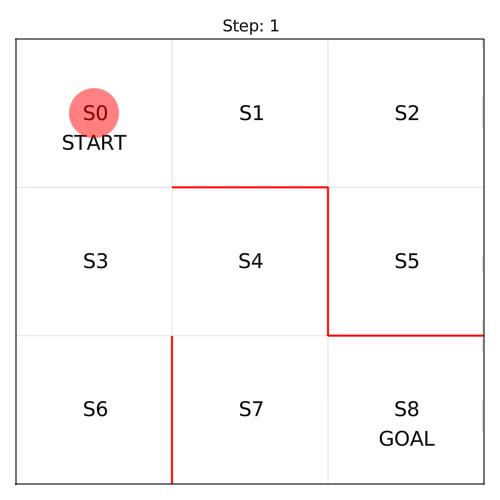

In [11]:
# ランダム行動の結果をプロット
save_anim(agent, event.records, "./img/01_04-random-action.gif")
display("image/gif", read("./img/01_04-random-action.gif"))

## パッケージ化

上記で概ねフレームワークの枠組みは出来上がったため、パッケージ化して再利用しやすくする

In [6]:
# Revise パッケージを読み込んで、開発中のパッケージの変更を自動で検知するようにする
using Revise, Pkg

# SimpleRL パッケージ開発
if !isdir("./SimpleRL")
    Pkg.generate("./SimpleRL")
end

Pkg.activate("./SimpleRL")
Pkg.add([
    "Test",
    "GLMakie",
    "NaNStatistics",
    "Distributions",
    "ProgressMeter"
])

  Activating project at `d:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL`
    Updating registry at `C:\Users\user\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `D:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL\Project.toml`
  No Changes to `D:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL\Manifest.toml`


In [7]:
# 開発したパッケージのコンパイルテスト
Pkg.precompile()

In [8]:
# 単体テスト実行
Pkg.test()

     Testing SimpleRL
      Status `C:\Users\user\AppData\Local\Temp\jl_c5LplP\Project.toml`
  [31c24e10] Distributions v0.25.65
  [e9467ef8] GLMakie v0.6.10
  [b946abbf] NaNStatistics v0.6.13
  [92933f4c] ProgressMeter v1.7.2
  [8f9bf27a] SimpleRL v0.1.0 `D:\github\julia_ml-tuto\04_reinforcement-learning\pytorch\SimpleRL`
  [8dfed614] Test `@stdlib/Test`
      Status `C:\Users\user\AppData\Local\Temp\jl_c5LplP\Manifest.toml`
  [621f4979] AbstractFFTs v1.2.1
  [1520ce14] AbstractTrees v0.4.2
  [79e6a3ab] Adapt v3.3.3
  [27a7e980] Animations v0.4.1
  [4fba245c] ArrayInterface v6.0.19
  [30b0a656] ArrayInterfaceCore v0.1.14
  [015c0d05] ArrayInterfaceOffsetArrays v0.1.6
  [b0d46f97] ArrayInterfaceStaticArrays v0.1.4
  [dd5226c6] ArrayInterfaceStaticArraysCore v0.1.0
  [67c07d97] Automa v0.8.2
  [13072b0f] AxisAlgorithms v1.0.1
  [62783981] BitTwiddlingConvenienceFunctions v0.1.4
  [fa961155] CEnum v0.4.2
  [2a0fbf3d] CPUSummary v0.1.23
  [49dc2e85] Calculus v0.5.1
  [d360d2e6] ChainRules

Test Summary: | Pass  Total
MazeEnv       |    4      4



  [3fa0cd96] REPL `@stdlib/REPL`
  [9a3f8284] Random `@stdlib/Random`
  [ea8e919c] SHA `@stdlib/SHA`
  [9e88b42a] Serialization `@stdlib/Serialization`
  [1a1011a3] SharedArrays `@stdlib/SharedArrays`
  [6462fe0b] Sockets `@stdlib/Sockets`
  [2f01184e] SparseArrays `@stdlib/SparseArrays`
  [10745b16] Statistics `@stdlib/Statistics`
  [4607b0f0] SuiteSparse `@stdlib/SuiteSparse`
  [fa267f1f] TOML `@stdlib/TOML`
  [a4e569a6] Tar `@stdlib/Tar`
  [8dfed614] Test `@stdlib/Test`
  [cf7118a7] UUIDs `@stdlib/UUIDs`
  [4ec0a83e] Unicode `@stdlib/Unicode`
  [e66e0078] CompilerSupportLibraries_jll `@stdlib/CompilerSupportLibraries_jll`
  [deac9b47] LibCURL_jll `@stdlib/LibCURL_jll`
  [29816b5a] LibSSH2_jll `@stdlib/LibSSH2_jll`
  [c8ffd9c3] MbedTLS_jll `@stdlib/MbedTLS_jll`
  [14a3606d] MozillaCACerts_jll `@stdlib/MozillaCACerts_jll`
  [4536629a] OpenBLAS_jll `@stdlib/OpenBLAS_jll`
  [05823500] OpenLibm_jll `@stdlib/OpenLibm_jll`
  [83775a58] Zlib_jll `@stdlib/Zlib_jll`
  [8e850b90] libblastramp